# Anomaly Detection using Gaussian Distribution (Fraud Detection)

Anomaly Detection is the process of identifying patterns or data points in a dataset that do not conform to expected behavior. These abnormal or anomalous points are also known as outliers. In machine learning, anomaly detection is widely used in various applications, such as fraud detection, network security, quality control, and more.

The goal is to model the data using Gaussian distributions and identify data points that significantly deviate from the normal data distribution, which are treated as anomalies.

This example uses synthetic transaction data with certain features (e.g., transaction amount, time of the day, geographical location, etc.) to model "normal" transactions. Any data points that significantly deviate from the learned distribution are flagged as potential fraudulent transactions (i.e., anomalies).

## Imports

- Numpy, Pandas for math/data

- Matplotlib for plotting

- Sklearn modules for modeling

- Multivariate Normal Distribution for Gaussian pdf

- make_blobs to simulate fake cluster data

In [176]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

## Create a Dataset with Outliers

- A dense cluster (400 points) centered at one point.

- Then you create 30 random outliers all over the place between -6 and +6.

- Combine (vstack) them into one dataset.

In [177]:
# Simulated dataset with anomalies
X, _ = make_blobs(n_samples=400, centers=1, cluster_std=0.6, random_state=42)

# Add some random anomalies
np.random.seed(42)
outliers = np.random.uniform(low=-6, high=6, size=(30, 2))
X = np.vstack([X, outliers])

print(f"Input Features Shape: {X.shape}")

Input Features Shape: (430, 2)


## Visualize Initial Data

- Basic scatter plot of all points, so you can visually verify outliers.

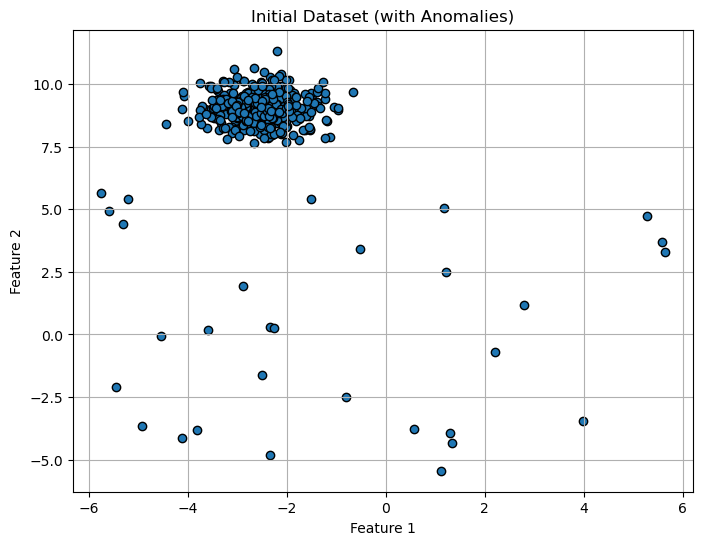

In [178]:
# Plot initial dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], edgecolors='k')
plt.title("Initial Dataset (with Anomalies)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

## Preprocess Data

Scaling features to zero mean, unit variance, because Gaussian assumes "nicely centered" data.

In [179]:
# Preprocessing (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train-Test Split

- Splitted the data into train/test (80% train, 20% test). Fake labels (all 0s for normal) because it's unsupervised.

In [180]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.zeros(X_scaled.shape[0]), test_size=0.2, random_state=42)

In [181]:
# Inject synthetic anomalies into training data
num_anomalies = int(0.05 * X_train.shape[0])
indices = np.random.choice(X_train.shape[0], num_anomalies, replace=False)
y_train[indices] = 1  # Mark these as anomalies

In [182]:
# Create fake labels (all 0) for normal data (unsupervised)
y_train = np.zeros(X_train.shape[0])
y_test = np.zeros(X_test.shape[0])

## Create Custom Gaussian Anomaly Detector Class

- .fit(X) = calculate mean (mu) and covariance (sigma) from data

- .predict(X) = calculate probability density; mark points with very low probability as anomalies.

In [183]:
# Custom Gaussian Anomaly Detector Class
class GaussianAnomalyDetector(BaseEstimator):
    def __init__(self, epsilon=0.01):
        self.epsilon = epsilon
        
    def fit(self, X, y=None):
        self.mu = np.mean(X, axis=0)
        self.sigma = np.cov(X, rowvar=False)
        self.model = multivariate_normal(mean=self.mu, cov=self.sigma)
        return self
    
    def predict(self, X):
        probs = self.model.pdf(X)
        return (probs < self.epsilon).astype(int)

## Train Initial Model

- Train the model with some initial epsilon (0.01).

In [184]:
# Train the model
model = GaussianAnomalyDetector(epsilon=0.01)
model.fit(X_train)

GaussianAnomalyDetector()

## Cross-Validation Evaluation

- 5-fold cross-validation to check model performance.

In [185]:
# Cross-validation Evaluation
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())


Cross-Validation Scores: [0.89855072 0.94202899 0.94202899 0.97101449 0.92647059]
Mean Cross-Validation Score: 0.9360187553282182


## Find the Best Epsilon (Threshold)

You try 1000 possible epsilons between min and max probability density.
For each epsilon:

- Predict anomalies

- Calculate F1 score

- Pick the best epsilon (which maximizes F1)

(This is hyperparameter tuning)

In [186]:
# Choosing Best Threshold (Epsilon)
probs_train = model.model.pdf(X_train)
probs_test = model.model.pdf(X_test)

epsilons = np.linspace(min(probs_train), max(probs_train), 1000)
best_f1 = 0
best_epsilon = 0

for eps in epsilons:
    preds = (probs_train < eps).astype(int)
    f1 = f1_score(y_train, preds, zero_division=1)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = eps

print("\nBest Epsilon Found:", best_epsilon)
print("Best F1-Score:", best_f1)


Best Epsilon Found: 7.074986799114017e-14
Best F1-Score: 1.0


## Retrain Model on Best Epsilon

- Rebuild model using the best epsilon.

In [187]:
# Retrain model with best epsilon
final_model = GaussianAnomalyDetector(epsilon=best_epsilon)
final_model.fit(X_train)

GaussianAnomalyDetector(epsilon=7.074986799114017e-14)

## Predict on Test Data

- Predict anomalies on your 20% test data.

In [188]:
# Test Prediction
predictions = final_model.predict(X_test)

## Plot Decision Boundary

Created a meshgrid from -4 to 4 for both axes.

Plot:

- Decision boundary (contour where pdf = epsilon)

- Test points colored by prediction (normal/anomaly)

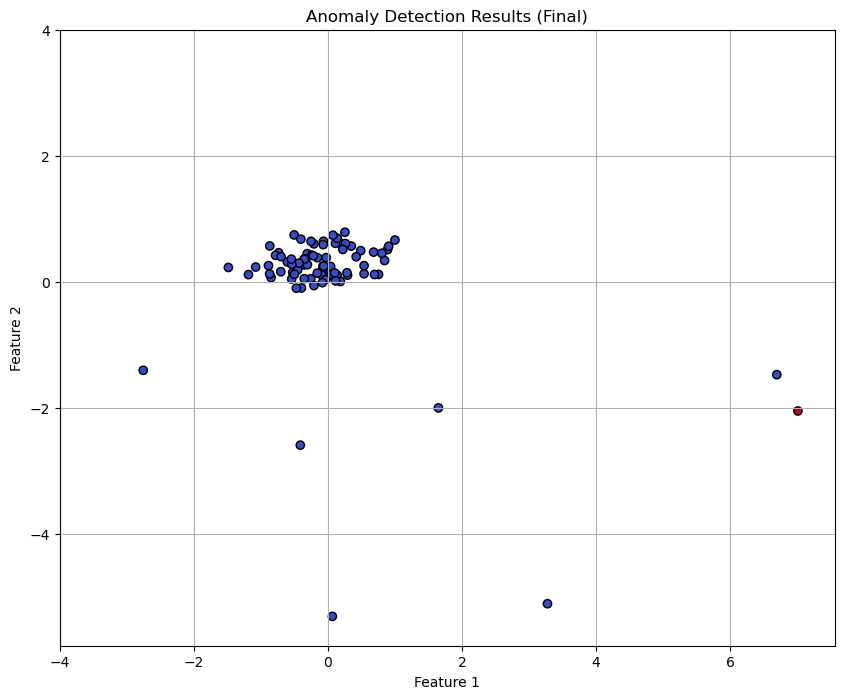

In [189]:
# Plot final decision boundary
x, y = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
Z = final_model.model.pdf(np.c_[x.ravel(), y.ravel()])
Z = Z.reshape(x.shape)

plt.figure(figsize=(10,8))
plt.contour(x, y, Z, levels=[best_epsilon], linewidths=2, colors='red')
plt.scatter(X_test[:,0], X_test[:,1], c=predictions, cmap='coolwarm', edgecolors='k')
plt.title("Anomaly Detection Results (Final)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

## Some Predictions

- Sample inputs and outputs to manually verify.

In [190]:
# Display First 10 Predictions
print("\nFirst 10 Test Inputs (scaled):")
print(X_test[:10])

print("\nFirst 10 Prediction Outputs (0=Normal, 1=Anomaly):")
print(predictions[:10])


First 10 Test Inputs (scaled):
[[-0.41161144 -2.58851168]
 [-0.25513274  0.04935906]
 [-0.73454164  0.46294659]
 [-0.52544171  0.14979541]
 [-0.86732442  0.5709064 ]
 [-0.50341141  0.74534759]
 [ 0.3480593   0.56834952]
 [-0.78012484  0.42096656]
 [-0.40355109  0.67803957]
 [ 0.19497996  0.61078663]]

First 10 Prediction Outputs (0=Normal, 1=Anomaly):
[0 0 0 0 0 0 0 0 0 0]


## Final Visualization

- Bigger mesh grid around entire data range (+/- 1 margin).

- Color-coded anomalies and normal points separately for visual clarity.
                                             
- Shows the red contour as the decision boundary.

In [191]:
# Final visualization
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [192]:
# Create grid
x, y = np.meshgrid(np.linspace(X_scaled[:,0].min()-1, X_scaled[:,0].max()+1, 500),
                   np.linspace(X_scaled[:,1].min()-1, X_scaled[:,1].max()+1, 500))

Z = final_model.model.pdf(np.c_[x.ravel(), y.ravel()])
Z = Z.reshape(x.shape)

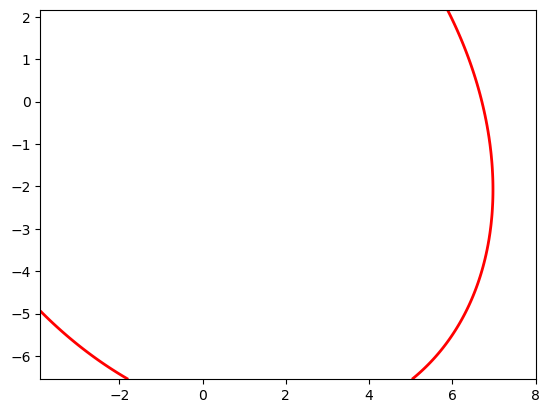

In [193]:
# Plot Gaussian contour
contour = plt.contour(x, y, Z, levels=[best_epsilon], linewidths=2, colors='red')

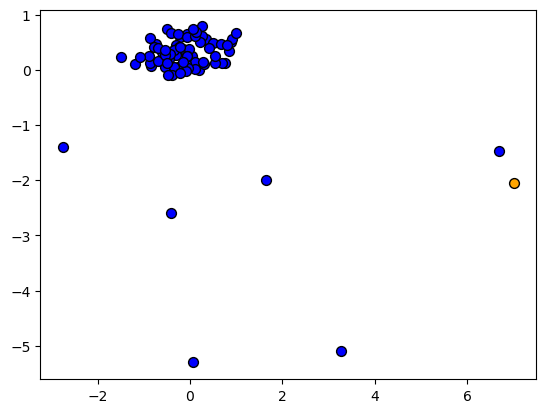

In [194]:
# Plot test points
plt.scatter(X_test[predictions==0, 0], X_test[predictions==0, 1], 
            c='blue', label='Normal', edgecolors='k', s=50)

plt.scatter(X_test[predictions==1, 0], X_test[predictions==1, 1], 
            c='orange', label='Anomaly', edgecolors='k', s=50)